# EEGnet SETTINGS

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from scipy.io import loadmat
from scipy import signal
from google.colab import drive
import warnings
import string
import os

from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

# Install mne library for topoplot
!pip install mne
import mne

warnings.filterwarnings('ignore')
drive.mount('/content/drive')

####################### SETTINGS ########################
# Set this variable with the desidered subject's letter #
SUBJECT_SELECTED = "B"                                  #
#########################################################

subject_names = ["A", "B"]

# Check for errors in the settings
if SUBJECT_SELECTED not in subject_names:
    raise ValueError("SUBJECT_SELECTED value {} is invalid.\nPlease enter one of the following parameters {}".format(SUBJECT_SELECTED, subject_names))

# Google drive data paths
MODEL_LOCATIONS_FILE_PATH = 'drive/MyDrive/project/model/EEGnet/' + SUBJECT_SELECTED
SUBJECT_TRAIN_FILE_PATH = 'drive/MyDrive/project/dataset/BCI_Comp_III_Wads_2004/Subject_' + SUBJECT_SELECTED + '_Train.mat'
SUBJECT_TEST_FILE_PATH = 'drive/MyDrive/project/dataset/BCI_Comp_III_Wads_2004/Subject_' + SUBJECT_SELECTED + '_Test.mat'
CHANNEL_LOCATIONS_FILE_PATH = 'drive/MyDrive/project/datasetBCI_Comp_III_Wads_2004/eloc64.txt'
#CHANNEL_COORD = 'drive/MyDrive/project/dataset/coordinates.csv'

# Channel selection
CHANNELS = [i for i in range(64)]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.6 MB/s eta 0:00:00
Mounted at /content/drive


#Exploring dataset


In [ ]:
data1 = loadmat("drive/MyDrive/project/dataset/BCI_Comp_III_Wads_2004/Subject_B_Train.mat")
data1_2 = loadmat("drive/MyDrive/project/dataset/BCI_Comp_III_Wads_2004/Subject_B_Test.mat")
data2 = loadmat("drive/MyDrive/project/dataset/BCI_Competition_IIb/AAS012R08.mat")
data3 = loadmat("drive/MyDrive/project/dataset/Subject_A_Train.mat")
data3_2 = loadmat("drive/MyDrive/project/dataset/Subject_A_Test.mat")

In [ ]:
print(data1.keys())
print(data1_2.keys())
print(data2.keys())
print(data3.keys())
print(data3_2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'Flashing', 'StimulusCode', 'TargetChar', 'StimulusType'])
dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'Flashing', 'StimulusCode'])
dict_keys(['__header__', '__version__', '__globals__', 'filename', 'evalstring', 'runnr', 'trialnr', 'samplenr', 'signal', 'SourceTime', 'StimulusCode', 'Flashing', 'PhaseInSequence', 'StimulusTime'])
dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])
dict_keys(['__header__', '__version__', '__globals__', 'Flashing', 'Signal', 'StimulusCode', 'TargetChar'])


# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Obtain windows of 650ms at the start of every flashing (175ms)
3.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
4.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
5.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;

In [ ]:
!ls drive/MyDrive/project/dataset/BCI_Comp_III_Wads_2004

eloc64.txt  Subject_A_Test.mat	 Subject_B_Test.mat   topoplotEEG.m
example.m   Subject_A_Train.mat  Subject_B_Train.mat


In [ ]:
if not os.path.exists(SUBJECT_TRAIN_FILE_PATH):
    print("Missing file: {}".format(SUBJECT_TRAIN_FILE_PATH))
else:
    # Load the required data
    data = loadmat(SUBJECT_TRAIN_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals = data['Signal']
    flashing = data['Flashing']
    stimulus = data['StimulusType']
    word = data['TargetChar']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION = (len(signals))*(len(signals[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS = len(word[0])#Subject_A_Train.mat 训练集包含 85 个字符；Subject_A_Test.mat 测试集包含 100 个字符
    # Set flag to True to balance the training set
    BALANCE_DATASET = False

    print("**********************************")
    print("       TRAIN SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION)
    print("Number of letters:  %d" % TRIALS)
    print("Spelled word:       %s" % ''.join(word))

**********************************
       TRAIN SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01 min
Number of letters:  85
Spelled word:       VGREAAH8TVRHBYN_UGCOLO4EUERDOOHCIFOMDNU6LQCPKEIREKOYRQIDJXPBKOJDWZEUEWWFOEBHXTQTTZUMO


In [ ]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS):
    signals[trial, :, :] = signal.filtfilt(b, a, signals[trial, :, :], axis=0)

In [ ]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing[trial, sample-1] == 0 and flashing[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals[trial, lower_sample:upper_sample, :]
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 64, 78)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

Features tensor shape: (15300, 156, 64)


In [ ]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Obtain windows of 650ms at the start of every flashing (175ms)
3.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
4.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
5.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [ ]:
# Test data loading
if not os.path.exists(SUBJECT_TEST_FILE_PATH):
    print("Missing file: {}", SUBJECT_TEST_FILE_PATH)
else:
    # Load the required data
    data_test = loadmat(SUBJECT_TEST_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals_test = data_test['Signal']
    flashing_test = data_test['Flashing']
    #word_test =  data_test['TargetChar']
    stimulus_code_test = data_test['StimulusCode']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    #TRIALS_TEST = len(word_test[0])
    TRIALS_TEST = 100  # 根据 BCI 2004 竞赛说明，测试集包含 100 个字符
    # Number of samples for each character in trials
    SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

    print("**********************************")
    print("        TEST SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
    print("Number of letters:  %d" % TRIALS_TEST)
    #print("Spelled word:       %s" % ''.join(word_test))

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12 min
Number of letters:  100


In [ ]:
# Create characters matrix
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
#stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.zeros_like(stimulus_code_test)  # 统一初始化为 0
stimulus_test = np.array(stimulus_test)

stimulus_test = np.zeros_like(stimulus_code_test)

In [ ]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [ ]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
#SAMPLES_PER_TRIAL_TEST = len(signals[0])
SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 78)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (18000, 156, 64)


In [ ]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

# EEGnet model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted dataset;
5.   CNN1 performance assessment;

In [ ]:
# Training parameters
BATCH_SIZE = 256
EPOCHS = 200
VALID_SPLIT = 0.05
SHUFFLE = 1 # set to 1 to shuffle subsets during training

In [ ]:
import sys
!git clone https://github.com/vlawhern/arl-eegmodels.git
sys.path.append('/content/arl-eegmodels')

Cloning into 'arl-eegmodels'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 112 (delta 1), reused 4 (delta 1), pack-reused 106 (from 1)
Receiving objects: 100% (112/112), 80.61 KiB | 7.33 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
!ls /content/arl-eegmodels

EEGModels.py  examples	LICENSE.txt  README.md


In [ ]:
print("Current sys.path:", sys.path)

Current sys.path: ['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/content/arl-eegmodels']


In [ ]:
from EEGModels import EEGNet
#import EEGNet
from tensorflow.keras.utils import to_categorical

# one-hot coding
train_labels = to_categorical(train_labels, num_classes=2)

eegnet_model = EEGNet(
    nb_classes=2,
    Chans=64,
    Samples=156,
    dropoutRate=0.5,
    kernLength=64,
    F1=8,
    D=2,
    F2=16,
    dropoutType='Dropout'
)

eegnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

eegnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 156, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 156, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 156, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 1, 156, 16)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 156, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 156, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 1, 39, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 39, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 1, 39, 16)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 39, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1, 39, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 1, 4, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,338 (9.13 KB)

 Trainable params: 2,258 (8.82 KB)

 Non-trainable params: 80 (320.00 B)

In [ ]:
train_features = np.transpose(train_features, (0, 2, 1))  #  (None, 64, 156)
train_features = np.expand_dims(train_features, axis=-1)  #  (None, 64, 156, 1)

print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)

Train features shape: (15300, 64, 156, 1)
Train labels shape: (15300, 2)


In [ ]:

# Model definition
model = eegnet_model

# Callback to save best model only
checkpoint = ModelCheckpoint(filepath=MODEL_LOCATIONS_FILE_PATH + "/" + "model" + ".h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor = 'val_loss',
                              mode = 'min',
                              patience = 50,
                              restore_best_weights = True)


# Callback to keep track of model statistics
history = model.fit(x=train_features,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VALID_SPLIT,
                    callbacks=[checkpoint, earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})

Epoch 1/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5937 - loss: 1.1402

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.5935 - loss: 1.1400 - val_accuracy: 0.5817 - val_loss: 0.6847
Epoch 2/200
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5944 - loss: 1.0857

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5953 - loss: 1.0841 - val_accuracy: 0.7320 - val_loss: 0.6318
Epoch 3/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6812 - loss: 0.9976

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6818 - loss: 0.9964 - val_accuracy: 0.7490 - val_loss: 0.5820
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7003 - loss: 0.9480

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7005 - loss: 0.9478 - val_accuracy: 0.7699 - val_loss: 0.5460
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7286 - loss: 0.9118

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7286 - loss: 0.9118 - val_accuracy: 0.7516 - val_loss: 0.5317
Epoch 6/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7311 - loss: 0.9052

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7311 - loss: 0.9053 - val_accuracy: 0.7647 - val_loss: 0.5184
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7318 - loss: 0.9120

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7319 - loss: 0.9117 - val_accuracy: 0.7922 - val_loss: 0.5046
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7484 - loss: 0.8877

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7482 - loss: 0.8877 - val_accuracy: 0.7647 - val_loss: 0.5024
Epoch 9/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7514 - loss: 0.8731 - val_accuracy: 0.7595 - val_loss: 0.5082
Epoch 10/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7428 - loss: 0.8757 - val_accuracy: 0.7739 - val_loss: 0.5031
Epoch 11/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7457 - loss: 0.8713 - val_accuracy: 0.7529 - val_loss: 0.5090
Epoch 12/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7506 - loss: 0.8468 - val_accuracy: 0.7634 - val_loss: 0.5121
Epoch 13/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7474 - loss: 0.8718

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7474 - loss: 0.8718 - val_accuracy: 0.7778 - val_loss: 0.4945
Epoch 14/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7556 - loss: 0.8490

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7556 - loss: 0.8492 - val_accuracy: 0.7752 - val_loss: 0.4868
Epoch 15/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7592 - loss: 0.8560 - val_accuracy: 0.7712 - val_loss: 0.4953
Epoch 16/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7623 - loss: 0.8329 - val_accuracy: 0.7765 - val_loss: 0.4919
Epoch 17/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7593 - loss: 0.8400

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7594 - loss: 0.8400 - val_accuracy: 0.7817 - val_loss: 0.4790
Epoch 18/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7593 - loss: 0.8638 - val_accuracy: 0.7765 - val_loss: 0.4794
Epoch 19/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7583 - loss: 0.8735

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7584 - loss: 0.8730 - val_accuracy: 0.7908 - val_loss: 0.4727
Epoch 20/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7628 - loss: 0.8628 - val_accuracy: 0.7948 - val_loss: 0.4763
Epoch 21/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7713 - loss: 0.8264 - val_accuracy: 0.7830 - val_loss: 0.4875
Epoch 22/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7659 - loss: 0.8440 - val_accuracy: 0.7778 - val_loss: 0.4788
Epoch 23/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7738 - loss: 0.8205 - val_accuracy: 0.7856 - val_loss: 0.4825
Epoch 24/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7643 - loss: 0.8388 - val_accuracy: 0.7882 - val_loss: 0.4805
Epoch 25/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7705 - loss: 0.8238 - val_accuracy: 0.7856 - val_loss: 0.4790
Epoch 26/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7752 - loss: 0.8396

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7751 - loss: 0.8394 - val_accuracy: 0.8065 - val_loss: 0.4636
Epoch 27/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7707 - loss: 0.8367 - val_accuracy: 0.7791 - val_loss: 0.4928
Epoch 28/200
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7617 - loss: 0.8328

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7621 - loss: 0.8324 - val_accuracy: 0.8065 - val_loss: 0.4616
Epoch 29/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7798 - loss: 0.8191 - val_accuracy: 0.8000 - val_loss: 0.4688
Epoch 30/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7672 - loss: 0.8360

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7672 - loss: 0.8359 - val_accuracy: 0.8209 - val_loss: 0.4495
Epoch 31/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7802 - loss: 0.8256 - val_accuracy: 0.8065 - val_loss: 0.4720
Epoch 32/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7692 - loss: 0.8125 - val_accuracy: 0.7856 - val_loss: 0.4770
Epoch 33/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7827 - loss: 0.8111 - val_accuracy: 0.8000 - val_loss: 0.4623
Epoch 34/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7779 - loss: 0.8148 - val_accuracy: 0.7843 - val_loss: 0.4635
Epoch 35/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7829 - loss: 0.8136 - val_accuracy: 0.7882 - val_loss: 0.4816
Epoch 36/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7756 - loss: 0.8216 - val_accuracy: 0.7804 - val_loss: 0.4849
Epoch 37/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7753 - loss: 0.8231 - val_accuracy: 0.7948 

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7984 - loss: 0.7868 - val_accuracy: 0.8118 - val_loss: 0.4483
Epoch 79/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7946 - loss: 0.7870 - val_accuracy: 0.8065 - val_loss: 0.4536
Epoch 80/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7927 - loss: 0.7751 - val_accuracy: 0.8131 - val_loss: 0.4505
Epoch 81/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7866 - loss: 0.8036 - val_accuracy: 0.8131 - val_loss: 0.4550
Epoch 82/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7984 - loss: 0.7685 - val_accuracy: 0.8078 - val_loss: 0.4552
Epoch 83/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7994 - loss: 0.7791 - val_accuracy: 0.8052 - val_loss: 0.4567
Epoch 84/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7958 - loss: 0.7926

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7957 - loss: 0.7925 - val_accuracy: 0.8235 - val_loss: 0.4401
Epoch 85/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8000 - loss: 0.7684 - val_accuracy: 0.8000 - val_loss: 0.4594
Epoch 86/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7943 - loss: 0.7828 - val_accuracy: 0.8065 - val_loss: 0.4500
Epoch 87/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7943 - loss: 0.7720 - val_accuracy: 0.8065 - val_loss: 0.4523
Epoch 88/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7955 - loss: 0.7878 - val_accuracy: 0.8131 - val_loss: 0.4461
Epoch 89/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7993 - loss: 0.7740 - val_accuracy: 0.8157 - val_loss: 0.4484
Epoch 90/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8009 - loss: 0.7822 - val_accuracy: 0.8131 - val_loss: 0.4486
Epoch 91/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7949 - loss: 0.7847 - val_accuracy: 0.8052 

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8007 - loss: 0.7893 - val_accuracy: 0.8078 - val_loss: 0.4391
Epoch 95/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8012 - loss: 0.7670 - val_accuracy: 0.8078 - val_loss: 0.4461
Epoch 96/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8026 - loss: 0.7763 - val_accuracy: 0.7935 - val_loss: 0.4516
Epoch 97/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7937 - loss: 0.7765 - val_accuracy: 0.8170 - val_loss: 0.4541
Epoch 98/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7944 - loss: 0.7841 - val_accuracy: 0.8209 - val_loss: 0.4406
Epoch 99/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7976 - loss: 0.7980 - val_accuracy: 0.8131 - val_loss: 0.4415
Epoch 100/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7943 - loss: 0.7756 - val_accuracy: 0.8065 - val_loss: 0.4470
Epoch 101/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7899 - loss: 0.7980

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7900 - loss: 0.7976 - val_accuracy: 0.8092 - val_loss: 0.4379
Epoch 102/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7993 - loss: 0.7635 - val_accuracy: 0.8144 - val_loss: 0.4431
Epoch 103/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7950 - loss: 0.7655 - val_accuracy: 0.8000 - val_loss: 0.4579
Epoch 104/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7896 - loss: 0.7774 - val_accuracy: 0.8222 - val_loss: 0.4450
Epoch 105/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8016 - loss: 0.7817 - val_accuracy: 0.8026 - val_loss: 0.4480
Epoch 106/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7877 - loss: 0.8054 - val_accuracy: 0.8196 - val_loss: 0.4391
Epoch 107/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7987 - loss: 0.7931

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7986 - loss: 0.7928 - val_accuracy: 0.8092 - val_loss: 0.4360
Epoch 108/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7979 - loss: 0.7713 - val_accuracy: 0.8105 - val_loss: 0.4561
Epoch 109/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7910 - loss: 0.7887 - val_accuracy: 0.8131 - val_loss: 0.4448
Epoch 110/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7989 - loss: 0.7837 - val_accuracy: 0.8131 - val_loss: 0.4408
Epoch 111/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7933 - loss: 0.7763 - val_accuracy: 0.8131 - val_loss: 0.4462
Epoch 112/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8013 - loss: 0.7787 - val_accuracy: 0.8183 - val_loss: 0.4463
Epoch 113/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7943 - loss: 0.7811 - val_accuracy: 0.8157 - val_loss: 0.4401
Epoch 114/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8098 - loss: 0.7500 - val_accuracy: 

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7890 - loss: 0.7837 - val_accuracy: 0.8366 - val_loss: 0.4341
Epoch 122/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8009 - loss: 0.7628 - val_accuracy: 0.8065 - val_loss: 0.4540
Epoch 123/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7954 - loss: 0.7704

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7954 - loss: 0.7704 - val_accuracy: 0.8288 - val_loss: 0.4339
Epoch 124/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8020 - loss: 0.7605 - val_accuracy: 0.8105 - val_loss: 0.4534
Epoch 125/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7913 - loss: 0.7748 - val_accuracy: 0.8131 - val_loss: 0.4430
Epoch 126/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8042 - loss: 0.7776

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8042 - loss: 0.7774 - val_accuracy: 0.8235 - val_loss: 0.4291
Epoch 127/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8025 - loss: 0.7807 - val_accuracy: 0.8183 - val_loss: 0.4363
Epoch 128/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8009 - loss: 0.7670 - val_accuracy: 0.8039 - val_loss: 0.4440
Epoch 129/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7924 - loss: 0.7845 - val_accuracy: 0.8052 - val_loss: 0.4470
Epoch 130/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7959 - loss: 0.7825 - val_accuracy: 0.8196 - val_loss: 0.4361
Epoch 131/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8031 - loss: 0.7821 - val_accuracy: 0.8144 - val_loss: 0.4388
Epoch 132/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8009 - loss: 0.7661 - val_accuracy: 0.8105 - val_loss: 0.4448
Epoch 133/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7938 - loss: 0.7825 - val_accuracy: 

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8048 - loss: 0.7705 - val_accuracy: 0.8261 - val_loss: 0.4255
Epoch 177/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8082 - loss: 0.7639 - val_accuracy: 0.8209 - val_loss: 0.4364
Epoch 178/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7974 - loss: 0.7708 - val_accuracy: 0.8131 - val_loss: 0.4329
Epoch 179/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8043 - loss: 0.7560 - val_accuracy: 0.8105 - val_loss: 0.4473
Epoch 180/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7933 - loss: 0.7729 - val_accuracy: 0.8235 - val_loss: 0.4283
Epoch 181/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8087 - loss: 0.7398 - val_accuracy: 0.8196 - val_loss: 0.4403
Epoch 182/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7961 - loss: 0.7643 - val_accuracy: 0.8144 - val_loss: 0.4299
Epoch 183/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8000 - loss: 0.7711 - val_accuracy: 

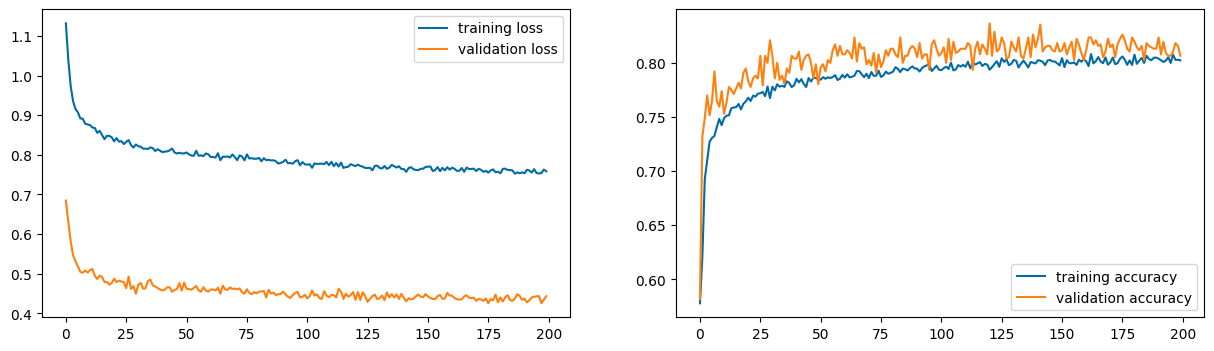

In [ ]:
plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

plt.show()

In [ ]:
# Define model
best_model = EEGNet(nb_classes=2,Chans=64,Samples=156,dropoutRate=0.5,kernLength=64,F1=8,D=2,F2=16,dropoutType='Dropout')

# Load best model weights from h5 file
best_model.load_weights(MODEL_LOCATIONS_FILE_PATH + "/model.h5")

# Compile best model model
best_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [ ]:
for i, w in enumerate(best_model.get_weights()):
    print(f"Weight {i}: Shape {w.shape}")

Weight 0: Shape (1, 64, 1, 8)
Weight 1: Shape (8,)
Weight 2: Shape (8,)
Weight 3: Shape (8,)
Weight 4: Shape (8,)
Weight 5: Shape (64, 1, 8, 2)
Weight 6: Shape (16,)
Weight 7: Shape (16,)
Weight 8: Shape (16,)
Weight 9: Shape (16,)
Weight 10: Shape (1, 16, 16, 1)
Weight 11: Shape (1, 1, 16, 16)
Weight 12: Shape (16,)
Weight 13: Shape (16,)
Weight 14: Shape (16,)
Weight 15: Shape (16,)
Weight 16: Shape (64, 2)
Weight 17: Shape (2,)


In [ ]:
import numpy as np
import os
import mne
import matplotlib.pyplot as plt

if not os.path.exists(CHANNEL_COORD):
    print("Missing file: {}".format(CHANNEL_COORD))
else:
    xycoord = []
    with open(CHANNEL_COORD, "r") as f:
        file_content = f.read()
        for row in file_content.split("\n"):
            if row == '':
                continue
            xycoord.append(row)

coord = np.array([list(map(float, x.split(','))) for x in xycoord], dtype=np.float64)

coord[:, 1] = 681 - coord[:, 1]

nf = np.abs(best_model.get_weights()[0])  # Shape (1, 64, 1, 8)
nf = nf.squeeze()  #  (64, 8)

num_filters = nf.shape[1]
print("NF shape:", nf.shape)  # (64, num_filters)
print("Coord shape:", coord.shape)  # (64, 2)

fig = plt.figure(figsize=(15,6))
for i in range(num_filters):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"Filter #{i+1}")
    mne.viz.plot_topomap(nf[:, i], coord, cmap='Spectral_r', axes=ax, show=False)

plt.show()


NameError: name 'CHANNEL_COORD' is not defined

In [ ]:
test_features = np.transpose(test_features, (0, 2, 1))  #  (None, 64, 78)
test_features = np.expand_dims(test_features, axis=-1)  #  (None, 64, 78, 1)

print("Updated test_features shape:", test_features.shape)  #  (18000, 64, 78, 1)

# 处理标签 (one-hot 编码)
test_labels = to_categorical(test_labels, num_classes=2)
print("Updated test_labels shape:", test_labels.shape)  #  (18000, 2)

Updated test_features shape: (18000, 64, 156, 1)
Updated test_labels shape: (18000, 2)


In [ ]:
print("Updated test_labels shape:", test_labels.shape)  #  (18000, 2)

Updated test_labels shape: (18000, 2)


In [ ]:
# Accuracy over the testing set
predictions = best_model.predict(test_features)
print("Predictions shape:", predictions.shape)
predictions = np.round(predictions)

predictions2 = np.argmax(predictions, axis=1)  # (18000,)
print("Updated predictions shape:", predictions2.shape)


score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
test_labels_for_print = np.argmax(test_labels, axis=1)
print("\nPredictions: {}\nSolutions:   {}".format(predictions2[:50].tolist(), test_labels_for_print[:50].tolist()))

563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Predictions shape: (18000, 2)
Updated predictions shape: (18000,)
Model performance on test set:	[ Loss: 0.1901	Accuracy: 0.74 ]

Predictions: [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


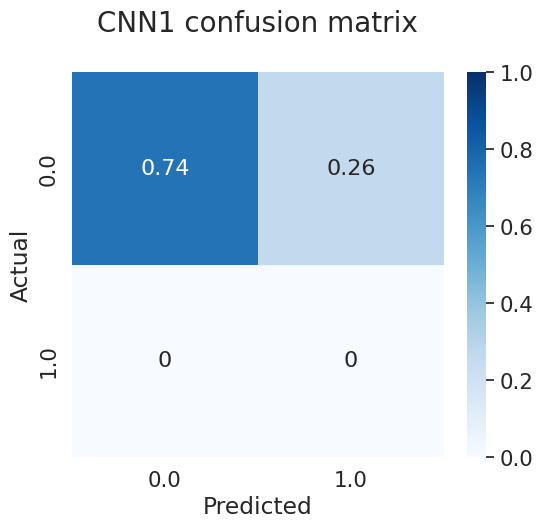

In [ ]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data = confusion_matrix(y_true=test_labels_for_print , y_pred=predictions2, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("CNN1 confusion matrix\n", fontsize=20)
plt.show()

In [ ]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

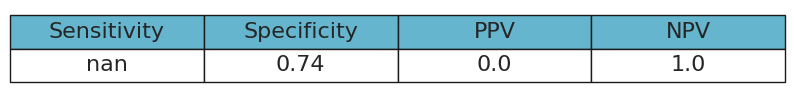

In [ ]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())],
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()